### 1. IMPORT PACKAGES

In [642]:
#!pip install pandas numpy yfinance matplotlib
#!pip install scikit-learn
#!pip install torch
#!pip install shap
#!pip install optuna

In [643]:
# Data Preprocessing
import datetime
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import randint, uniform

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import optuna


### 2. DATASET

In [654]:
# Set the start and end dates
start_time_all = datetime.datetime(2019, 7, 1) # 2020-01-01
end_time_train = datetime.datetime(2020, 9, 8) # 2020-06-30
end_time_all = datetime.datetime(2020, 12, 1) # 2020-12-31

# Download TSLA data
tsla_price_df = yf.download('TSLA', start=start_time_all, end=end_time_all)
tsla_price_df.index = pd.to_datetime(tsla_price_df.index)

# Split the dataset into training and testing sets (80% training, 20% testing)
train_df, test_df = train_test_split(tsla_price_df, test_size=0.2, shuffle=False)


[*********************100%***********************]  1 of 1 completed


In [645]:
tsla_price_df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2019-07-01 00:00:00+00:00,15.144667,15.144667,15.540000,15.085333,15.347333,123201000
2019-07-02 00:00:00+00:00,14.970000,14.970000,15.276667,14.814667,15.259333,138885000
2019-07-03 00:00:00+00:00,15.660000,15.660000,16.104668,15.634000,15.959333,213016500
2019-07-05 00:00:00+00:00,15.540000,15.540000,15.696667,15.386667,15.638000,105985500
2019-07-08 00:00:00+00:00,15.356000,15.356000,15.483333,15.244000,15.416000,88207500


In [646]:
tsla_price_df.tail()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2020-11-23 00:00:00+00:00,173.949997,173.949997,175.333328,167.263336,167.833328,150780900
2020-11-24 00:00:00+00:00,185.126663,185.126663,186.663330,175.399994,180.133331,160945500
2020-11-25 00:00:00+00:00,191.333328,191.333328,191.333328,181.789993,183.353333,146790600
2020-11-27 00:00:00+00:00,195.253326,195.253326,199.593338,192.816666,193.720001,112683300
2020-11-30 00:00:00+00:00,189.199997,189.199997,202.600006,184.836670,200.736664,189009300


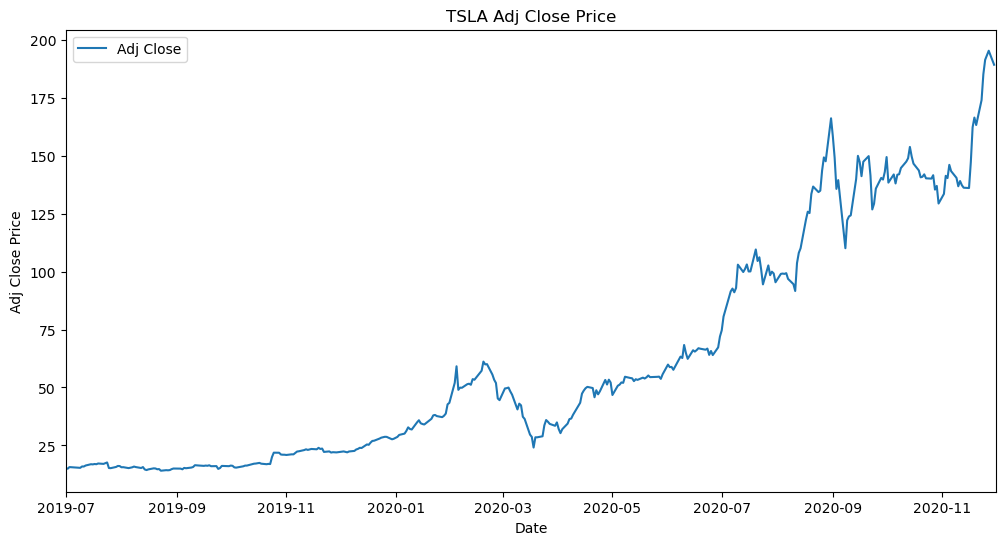

In [647]:
# Features variables (Close price, High price, Low price, Open price, Volume)
X = tsla_price_df.iloc[:, 1:6]

# Traget variable (Adj Close price)
y = tsla_price_df.iloc[:, 0:1]

# TSLA Adj Close price from 2020-01-01 to 2020-12-31
plt.figure(figsize=(12, 6))
plt.plot(tsla_price_df.index, y, label='Adj Close')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.xlim(start_time_all, end_time_all)
plt.title('TSLA Adj Close Price')
plt.legend()
plt.show()

### 3. NORMALIZATION OF DATA

In [648]:
# Normalize the features (Close, High, Low, Open, Volume)
features = ['Close', 'High', 'Low', 'Open', 'Volume']
scaler_features = MinMaxScaler()
train_features = scaler_features.fit_transform(train_df[features])
test_features = scaler_features.transform(test_df[features])

# Create a new DataFrame with the normalized features
train_features_df = pd.DataFrame(train_features, columns=features, index=train_df.index)
test_features_df = pd.DataFrame(test_features, columns=features, index=test_df.index)

# Normalize the target column ('Adj Close') separately
scaler_target = MinMaxScaler(feature_range=(0, 1))
train_target = scaler_target.fit_transform(train_df[['Adj Close']].values)
test_target = scaler_target.transform(test_df[['Adj Close']].values)

# Create a new DataFrame with the normalized target
train_target_df = pd.DataFrame(train_target, columns=['Adj Close'], index=train_df.index)
test_target_df = pd.DataFrame(test_target, columns=['Adj Close'], index=test_df.index)

# Combine the features and target DataFrames
train_data = pd.concat([train_features_df, train_target_df], axis=1)
test_data = pd.concat([test_features_df, test_target_df], axis=1)

train_data, val_data = train_test_split(train_data, test_size=0.15, shuffle=False)

# Print the first records of normalized data and the dimensions of the tensors
print("First records of normalized data (features):")
print(train_features_df.head())

print("\nFirst records of normalized data (target):")
print(train_target[:5])

First records of normalized data (features):
                              Close      High       Low      Open    Volume
Date                                                                       
2019-07-01 00:00:00+00:00  0.009411  0.010580  0.009351  0.009855  0.098298
2019-07-02 00:00:00+00:00  0.007848  0.008269  0.006866  0.009072  0.116180
2019-07-03 00:00:00+00:00  0.014024  0.015536  0.014387  0.015302  0.200699
2019-07-05 00:00:00+00:00  0.012950  0.011955  0.012117  0.012442  0.078670
2019-07-08 00:00:00+00:00  0.011303  0.010083  0.010807  0.010466  0.058401

First records of normalized data (target):
[[0.00941105]
 [0.00784752]
 [0.01402407]
 [0.01294989]
 [0.01130281]]


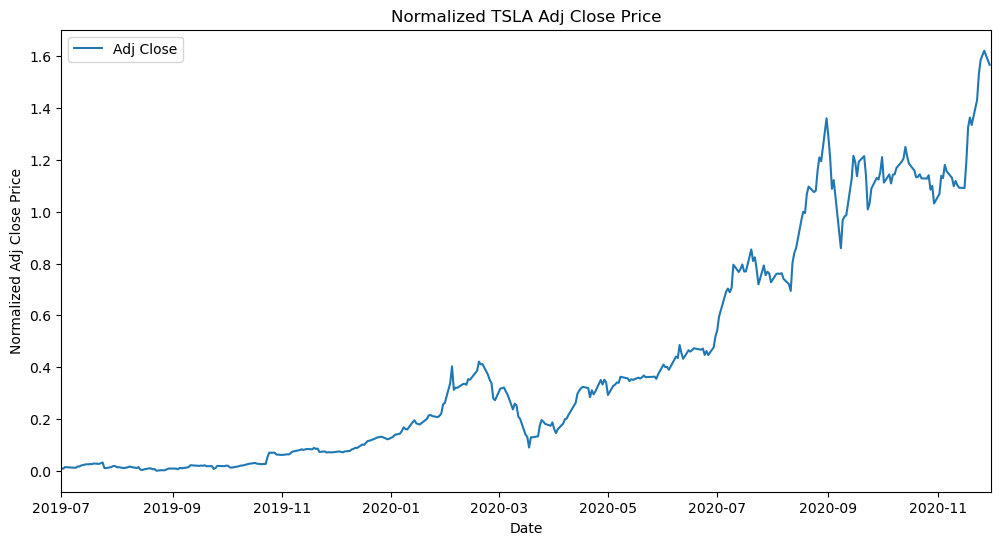

In [649]:
plt.figure(figsize=(12, 6))
plt.plot(tsla_price_df.index, scaler_target.transform(tsla_price_df[['Adj Close']]), label='Adj Close')
plt.xlabel('Date')
plt.ylabel('Normalized Adj Close Price')
plt.xlim(start_time_all, end_time_all)
plt.title('Normalized TSLA Adj Close Price')
plt.legend()
plt.show()

### 4. LSTM MODEL DEFINITION

In [650]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length), :-1]  # Características
        y = data[i + seq_length, -1]       # Variable objetivo
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 15
train_array = train_data.values
val_array = val_data.values

X_train, y_train = create_sequences(train_array, seq_length)
X_val, y_val = create_sequences(val_array, seq_length)

import torch
from torch.utils.data import TensorDataset, DataLoader

# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Crear datasets y dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)


In [651]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


### 5. LSTM MODEL 1.0

Epoch 5/100, Loss: 0.0187, Val Loss: 0.2760
Epoch 10/100, Loss: 0.0132, Val Loss: 0.2415
Epoch 15/100, Loss: 0.0046, Val Loss: 0.0091
Epoch 20/100, Loss: 0.0031, Val Loss: 0.1046
Epoch 25/100, Loss: 0.0018, Val Loss: 0.0085
Epoch 30/100, Loss: 0.0017, Val Loss: 0.0099
Epoch 35/100, Loss: 0.0014, Val Loss: 0.0187
Epoch 40/100, Loss: 0.0015, Val Loss: 0.0080
Epoch 45/100, Loss: 0.0014, Val Loss: 0.0064
Epoch 50/100, Loss: 0.0012, Val Loss: 0.0058
Epoch 55/100, Loss: 0.0012, Val Loss: 0.0055
Epoch 60/100, Loss: 0.0011, Val Loss: 0.0053
Epoch 65/100, Loss: 0.0011, Val Loss: 0.0057
Epoch 70/100, Loss: 0.0011, Val Loss: 0.0056
Epoch 75/100, Loss: 0.0010, Val Loss: 0.0057
Epoch 80/100, Loss: 0.0010, Val Loss: 0.0065
Epoch 85/100, Loss: 0.0009, Val Loss: 0.0077
Epoch 90/100, Loss: 0.0010, Val Loss: 0.0124
Epoch 95/100, Loss: 0.0010, Val Loss: 0.0133
Epoch 100/100, Loss: 0.0008, Val Loss: 0.0126


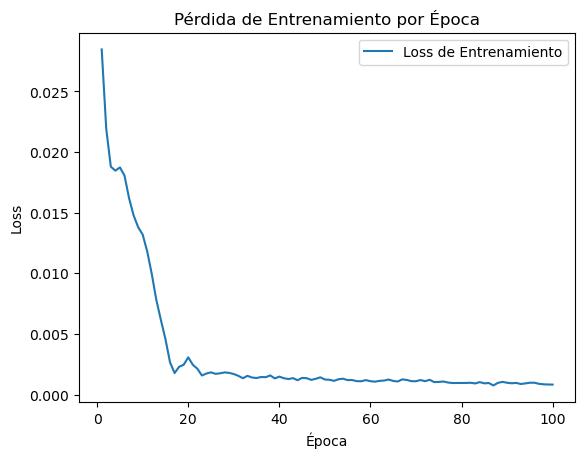

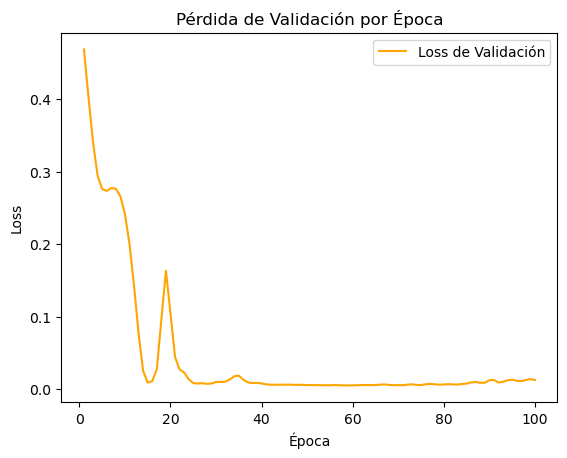

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Basic Hyperparameters
input_size = X_train.shape[2]
hidden_size = 50
num_layers = 2
dropout_prob = 0.2

# Initialize the LSTM model
model = LSTMModel(input_size, hidden_size, num_layers, dropout_prob).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

train_losses_over_epochs = []
val_losses_over_epochs = []

# Train the model
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    
    # Training loss
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_losses.append(loss.item())
    
    avg_train_loss = sum(train_losses) / len(train_losses)
    train_losses_over_epochs.append(avg_train_loss)
    
    # Validation loss
    model.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(X_batch)
            val_loss = criterion(outputs.squeeze(), y_batch)
            val_losses.append(val_loss.item())
            
    avg_val_loss = sum(val_losses) / len(val_losses)
    val_losses_over_epochs.append(avg_val_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plot the training and validation losses
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses_over_epochs, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, num_epochs+1), val_losses_over_epochs, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss per Epoch')
plt.legend()
plt.show()

Test MSE: 491.4764
Test MAE: 19.6753
Test RMSE: 22.1693


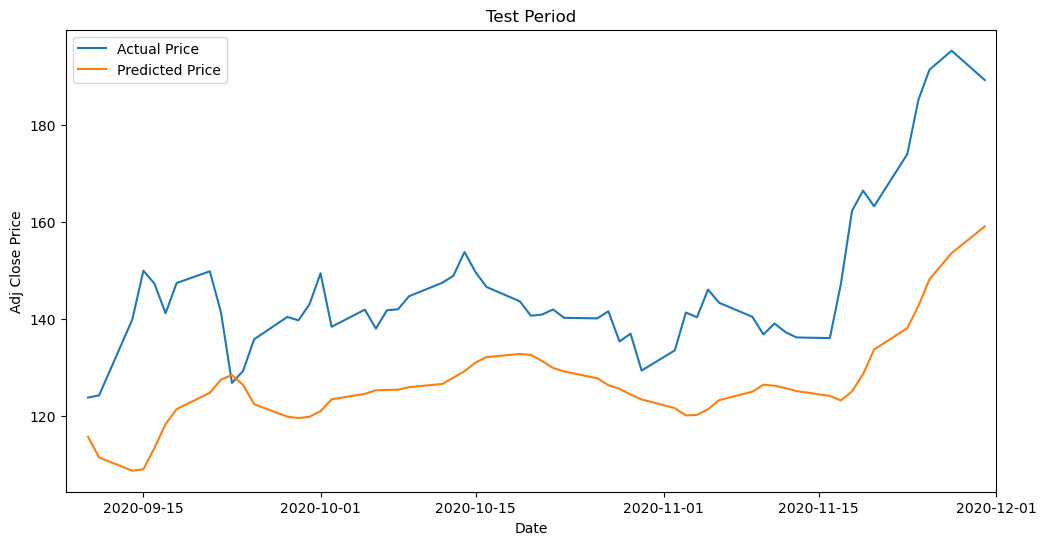

In [ ]:
# Set the model to evaluation mode
test_array = test_data.values
X_test, y_test = create_sequences(test_array, seq_length)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)

# Rescale the predicted and actual values
predictions = predictions.numpy()
y_test = y_test_tensor.numpy()
y_pred_rescaled = scaler_target.inverse_transform(predictions)
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")

# Adaptation of the plotting function for predictions
def plt_graph(start_time, end_time, period, val_line=False):
    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index[seq_length:], y_test_rescaled, label='Actual Price')
    plt.plot(test_data.index[seq_length:], y_pred_rescaled, label='Predicted Price')
    
    if val_line:
        plt.axvline(x=end_time_train, c='r', linestyle='--')
    
    plt.xlabel('Date')
    plt.ylabel('Adj Close Price')
    plt.xlim(start_time, end_time)
    plt.title(f'{period} Period')
    plt.legend()
    plt.show()

plt_graph(start_time=end_time_train, end_time=end_time_all, period='Test')

### 6. HYPERPARAMETERS TUNNING

In [ ]:
def objective(trial):
    # Define the hyperparameters to optimize
    hidden_size = trial.suggest_int('hidden_size', 32, 128)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    dropout_prob = trial.suggest_float('dropout_prob', 0.1, 0.5)

    # Define the model, loss function, and optimizer
    input_size = X_train.shape[2]
    model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout_prob).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    num_epochs = 50

    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_losses.append(loss.item())

    # Evaluate the model on the validation set
    model.eval()
    val_losses = []
    preds_list = []
    y_val_list = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            val_loss = criterion(outputs.squeeze(), y_batch)
            val_losses.append(val_loss.item())
            preds_list.extend(outputs.squeeze().cpu().numpy())
            y_val_list.extend(y_batch.cpu().numpy())

    avg_val_loss = np.mean(val_losses)

    # Rescale the predicted and actual values
    y_pred_rescaled = scaler_target.inverse_transform(np.array(preds_list).reshape(-1, 1))
    y_val_rescaled = scaler_target.inverse_transform(np.array(y_val_list).reshape(-1, 1))

    # Calculate metrics
    mse = mean_squared_error(y_val_rescaled, y_pred_rescaled)
    mae = mean_absolute_error(y_val_rescaled, y_pred_rescaled)
    rmse = np.sqrt(mse)
    trial.set_user_attr('val_mae', mae)
    trial.set_user_attr('val_rmse', rmse)

    return avg_val_loss

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
best_params = study.best_params
best_trial = study.best_trial

# Print the best parameters and metrics
print("\nBest parameters:")
print(best_params)
print(f"Best MSE: {study.best_value}")
print(f"Best MAE: {best_trial.user_attrs['val_mae']}")
print(f"Best RMSE: {best_trial.user_attrs['val_rmse']}")


[I 2024-11-09 00:24:01,058] A new study created in memory with name: no-name-19fb2cb5-0300-463d-b0fd-14cbed91e7ce
c:\Users\deloz\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3524524577100162 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-11-09 00:24:03,241] Trial 0 finished with value: 0.003757167374715209 and parameters: {'hidden_size': 116, 'num_layers': 1, 'learning_rate': 0.0020847867444912364, 'dropout_prob': 0.3524524577100162}. Best is trial 0 with value: 0.003757167374715209.
c:\Users\deloz\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.37917895249492994 and num_layers=1
  warnings.warn("dropout option adds dropout after

Mejores parámetros encontrados:
{'hidden_size': 48, 'num_layers': 1, 'learning_rate': 0.007705367743990691, 'dropout_prob': 0.3170658839244954}
Mejor pérdida de validación (MSE): 0.0029435993637889624
Mejor MAE en validación: 4.406367301940918
Mejor RMSE en validación: 6.060964107513428


### 7. LSTM MODEL 2.0

c:\Users\deloz\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3170658839244954 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 5/50, Loss: 0.0188, Val Loss: 0.3260
Epoch 10/50, Loss: 0.0140, Val Loss: 0.2305
Epoch 15/50, Loss: 0.0075, Val Loss: 0.1108
Epoch 20/50, Loss: 0.0012, Val Loss: 0.0126
Epoch 25/50, Loss: 0.0013, Val Loss: 0.0089
Epoch 30/50, Loss: 0.0012, Val Loss: 0.0080
Epoch 35/50, Loss: 0.0010, Val Loss: 0.0053
Epoch 40/50, Loss: 0.0010, Val Loss: 0.0051
Epoch 45/50, Loss: 0.0009, Val Loss: 0.0056
Epoch 50/50, Loss: 0.0009, Val Loss: 0.0054


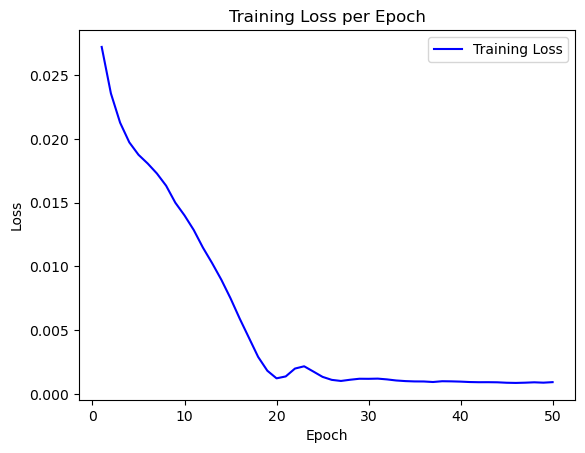

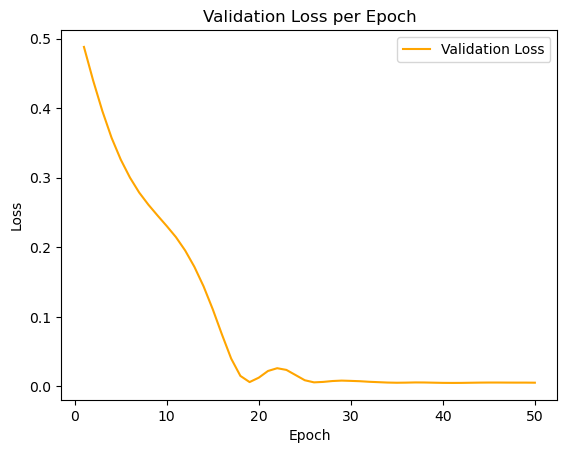

In [685]:
# Set the best hyperparameters
best_hidden_size = best_params['hidden_size']
best_num_layers = best_params['num_layers']
best_learning_rate = best_params['learning_rate']
best_dropout_prob = best_params['dropout_prob']
input_size = X_train.shape[2]

# Initialize the LSTM model with the best hyperparameters
model = LSTMModel(
    input_size=input_size,
    hidden_size=best_hidden_size,
    num_layers=best_num_layers,
    dropout=best_dropout_prob
).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50

train_losses_over_epochs = []
val_losses_over_epochs = []

# Train the model
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    
    # Training loss
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_losses.append(loss.item())
    
    avg_train_loss = sum(train_losses) / len(train_losses)
    train_losses_over_epochs.append(avg_train_loss)
    
    # Validation loss
    model.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(X_batch)
            val_loss = criterion(outputs.squeeze(), y_batch)
            val_losses.append(val_loss.item())
            
    avg_val_loss = sum(val_losses) / len(val_losses)
    val_losses_over_epochs.append(avg_val_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Plot the training and validation losses
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses_over_epochs, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, num_epochs+1), val_losses_over_epochs, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss per Epoch')
plt.legend()
plt.show()

Test MSE: 275.1525
Test MAE: 12.7764
Test RMSE: 16.5877


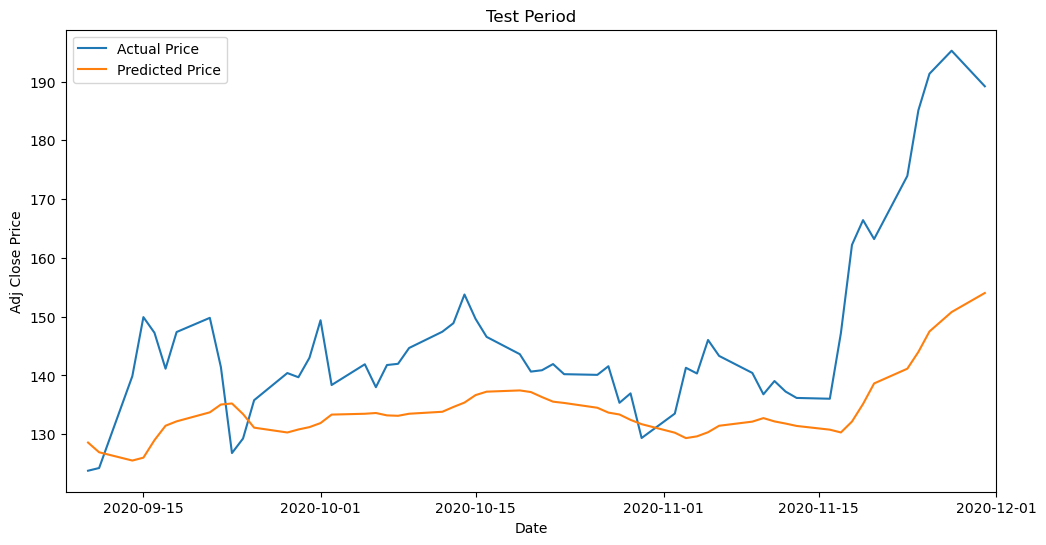

In [687]:
# Set the model to evaluation mode
test_array = test_data.values
X_test, y_test = create_sequences(test_array, seq_length)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)

# Rescale the predicted and actual values
predictions = predictions.numpy()
y_test = y_test_tensor.numpy()
y_pred_rescaled = scaler_target.inverse_transform(predictions)
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")

# Adaptation of the plotting function for predictions
def plt_graph(start_time, end_time, period, val_line=False):
    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index[seq_length:], y_test_rescaled, label='Actual Price')
    plt.plot(test_data.index[seq_length:], y_pred_rescaled, label='Predicted Price')
    
    if val_line:
        plt.axvline(x=end_time_train, c='r', linestyle='--')
    
    plt.xlabel('Date')
    plt.ylabel('Adj Close Price')
    plt.xlim(start_time, end_time)
    plt.title(f'{period} Period')
    plt.legend()
    plt.show()

plt_graph(start_time=end_time_train, end_time=end_time_all, period='Test')